# Quality


**Method**:
* Dense probe
* We chose to reproduce Horvath depths, to enable comparison with in vivo. This layout does not cover the entire column. Thus we calculate the ratios of sorted unit qualities for each layers separately, to avoid distribution bias caused by the overrepresentation of a layer.
* Consistently we previous analyses, we analyse layer 1 and 2/3 from depth 1, 4 and 5 from depth 2 and 6 from depth 3

### Setup

Create or activate env `spikeinterf...`

In [66]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spikeinterface as si

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes.analysis.failures import accuracy as acc
from src.nodes.metrics.metrics import get_firing_rate
from src.nodes.metrics import quality
from src.nodes.metrics.quality import get_scores_for_dense_probe as gscdp
from src.nodes.metrics.quality import get_chance_for_dense_probe as gchdp
from src.nodes.metrics.quality import combine_quality_across_dense_probe as cqadb


# PARAMETERS
DUR = 600 # 10 minutes recording
DT = 1.3 # ms (optimized)
THR_GOOD = 0.8

# DATASETS

# NPX
# depth 1
cfg_ds1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
K4_d1 = cfg_ds1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d1 = cfg_ds1["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d1 = cfg_ds1["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d1 = cfg_ds1["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d1 = cfg_ds1["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d1 = cfg_ds1["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d1 = cfg_ds1["probe_wiring"]["full"]["output"]
T_d1 = cfg_ds1["sorting"]["simulation"]["ground_truth"]["10m"]["output"]

# depth 2
cfg_ds2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
K4_d2 = cfg_ds2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d2 = cfg_ds2["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d2 = cfg_ds2["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d2 = cfg_ds2["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d2 = cfg_ds2["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d2 = cfg_ds2["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d2 = cfg_ds2["probe_wiring"]["full"]["output"]
T_d2 = cfg_ds2["sorting"]["simulation"]["ground_truth"]["10m"]["output"]

# depth 3
cfg_ds3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
K4_d3 = cfg_ds3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d3 = cfg_ds3["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d3 = cfg_ds3["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d3 = cfg_ds3["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d3 = cfg_ds3["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d3 = cfg_ds3["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d3 = cfg_ds3["probe_wiring"]["full"]["output"]
T_d3 = cfg_ds3["sorting"]["simulation"]["ground_truth"]["10m"]["output"]

# pre-computed qualities
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/sorting_quality.csv"

# FIGURE SETTINGS
# ticks
N_MJ_TCKS = 5
N_MN_TCKS = 11

# colors
# quality colors
cl = {"good": [0.7, 0.1, 0.1], # strong red
      "oversplitter": [0.6, 0.9, 0.6], # blue
      "overmerger": [0, 0.7, 1], # green
      "mixed: good + overmerger": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + oversplitter": np.array([[0.7, 0.1, 0.1], [0.6, 0.9, 0.6]]).mean(axis=0),
      "mixed: overmerger + oversplitter": np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + overmerger + oversplitter": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1],[0.6, 0.9, 0.6]]).mean(axis=0),
      "false positive": [1,1,1] # black
}

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-08-29 11:21:51,428 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-29 11:21:51,458 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-29 11:21:51,460 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-29 11:21:51,507 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-29 11:21:51,508 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-29 11:21:51,557 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (14s)Scores

* 10 minutes recordings
* sorted single-units only
* sorted units filtered such that there is no overepresentation of a layer: from L1, L2/3 from depth 1, L4,5 (depth 2), L6 (depth 3)


In [2]:
# KS4
(k4_sc, k4_so, k4_t) = gscdp(K4_d1, K4_d2, K4_d3, T_d1, T_d2, T_d3, DT)
# KS3
(k3_sc, k3_so, k3_t) = gscdp(K3_d1, K3_d2, K3_d3, T_d1, T_d2, T_d3, DT)
# KS2.5
(k25_sc, k25_so, k25_t) = gscdp(K25_d1, K25_d2, K25_d3, T_d1, T_d2, T_d3, DT)
# KS2
(k2_sc, k2_so, k2_t) = gscdp(K2_d1, K2_d2, K2_d3, T_d1, T_d2, T_d3, DT)
# KS
(K_sc, K_so, K_t) = gscdp(K_d1, K_d2, K_d3, T_d1, T_d2, T_d3, DT)
# HS
(H_sc, H_so, H_t) = gscdp(H_d1, H_d2, H_d3, T_d1, T_d2, T_d3, DT)

### (11s)Chance scores

* sorted single-units only
* chance scores are derived theoretically

In [3]:
# KS4
k4_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **k4_sc, **k4_so, **k4_t)
# KS3
k3_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **k3_sc, **k3_so, **k3_t)
# KS2.5
k25_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **k25_sc, **k25_so, **k25_t)
# KS2
k2_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **k2_sc, **k2_so, **k2_t)
# KS
K_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **K_sc, **K_so, **K_t)
# HS
H_ch = gchdp(DUR, DT, R_d1, R_d2, R_d3, **H_sc, **H_so, **H_t)

### (11m)Sorted unit quality

In [4]:
# compute quality (across depths, without redundancy)
# KS4
df_ds_ks4 = cqadb(THR_GOOD, K4_d1, K4_d2, K4_d3, **k4_sc, **k4_ch)
# KS3
df_ds_ks3 = cqadb(THR_GOOD, K3_d1, K3_d2, K3_d3, **k3_sc, **k3_ch)
# KS2.5
df_ds_ks25 = cqadb(THR_GOOD, K25_d1, K25_d2, K25_d3, **k25_sc, **k25_ch)
# KS2
df_ds_ks2 = cqadb(THR_GOOD, K2_d1, K2_d2, K2_d3, **k2_sc, **k2_ch)
# KS
df_ds_ks = cqadb(THR_GOOD, K_d1, K_d2, K_d3, **K_sc, **K_ch)
# HS
df_ds_h = cqadb(THR_GOOD, H_d1, H_d2, H_d3, **H_sc, **H_ch)

In [88]:
# set experiment and sorter
df_ds_ks4["sorter"] = "KS4"
df_ds_ks4["experiment"] = "DS"
df_ds_ks3["sorter"] = "KS3"
df_ds_ks3["experiment"] = "DS"
df_ds_ks25["sorter"] = "KS2.5"
df_ds_ks25["experiment"] = "DS"
df_ds_ks2["sorter"] = "KS2"
df_ds_ks2["experiment"] = "DS"
df_ds_ks["sorter"] = "KS"
df_ds_ks["experiment"] = "DS"
df_ds_h["sorter"] = "HS"
df_ds_h["experiment"] = "DS"
df_ds = pd.concat([df_ds_ks4, df_ds_ks3, df_ds_ks25, df_ds_ks2, df_ds_ks, df_ds_h])

### Plot by experiment x sorter

In [ ]:
# plot - kilosort 4
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "KS4"], cl, legend_cfg)

# plot - kilosort 3
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "KS3"], cl, legend_cfg)

# plot - kilosort 2.5
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "KS2.5"], cl, legend_cfg)

# plot - kilosort 2
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "KS2"], cl, legend_cfg)

# plot - kilosort
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "KS"], cl, legend_cfg)

# plot - herdingspikes
ax = quality.plot_ratio_by_exp(df_ds[df_ds["sorter"] == "HS"], cl, legend_cfg)

### Plot by sorter



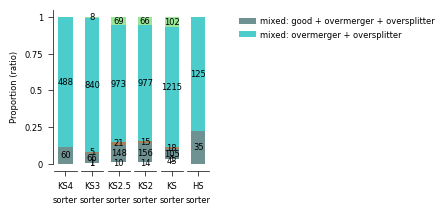

In [113]:
# TODO:
# - fix legend
args = {"color": cl, "lgd_cfg": legend_cfg}

# KS4
fig, ax = plt.subplots(1, 6, figsize=(2, 2))
ax = quality.plot_ratio_by_sorter(ax, df_ds[df_ds["experiment"] == "DS"], **args)

### Plot by layer x sorter (supp)

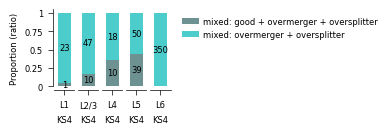

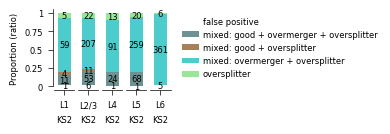

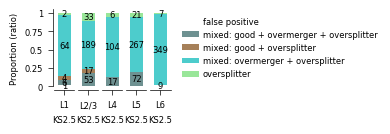

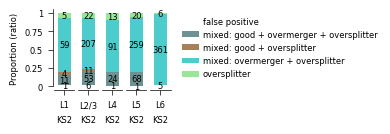

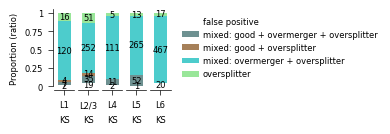

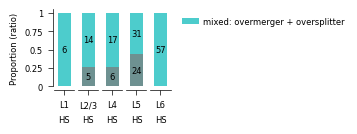

In [93]:
args = {"color": cl, "lgd_cfg": legend_cfg}

# KS4
fig, ax = plt.subplots(1, 5, figsize=(1.5, 1))
ax = quality.plot_ratio_by_layer(ax, df_ds[df_ds["sorter"] == "KS4"], **args)
# KS3
fig, ax2 = plt.subplots(1, 5, figsize=(1.5, 1))
ax2 = quality.plot_ratio_by_layer(ax2, df_ds[df_ds["sorter"] == "KS2"], **args)
# KS2.5
fig, ax3 = plt.subplots(1, 5, figsize=(1.5, 1))
ax3 = quality.plot_ratio_by_layer(ax3, df_ds[df_ds["sorter"] == "KS2.5"], **args)
# KS2
fig, ax4 = plt.subplots(1, 5, figsize=(1.5, 1))
ax4 = quality.plot_ratio_by_layer(ax4, df_ds[df_ds["sorter"] == "KS2"], **args)
# KS
fig, ax5 = plt.subplots(1, 5, figsize=(1.5, 1))
ax5 = quality.plot_ratio_by_layer(ax5, df_ds[df_ds["sorter"] == "KS"], **args)
# HS
fig, ax6 = plt.subplots(1, 5, figsize=(1.5, 1))
ax6 = quality.plot_ratio_by_layer(ax6, df_ds[df_ds["sorter"] == "HS"], **args)

### References

(1) https://neuronaldynamics.epfl.ch/online/Ch7.S2.html